In [21]:
import numpy  as np                       
import matplotlib.pyplot as plt
import scipy.linalg.interpolative as sli
import time, sys  
import random

time: 365 µs


In [24]:
%matplotlib inline
#%%capture
#!pip install ipython-autotime
%reload_ext autotime

time: 362 µs


In [3]:
# code settings
nx_lf     = 32
nx_hf     = 256
samples   = 100
eps       = 1e-6
save_plot = 0 # toggle flag to save figures
transf    = 0 # toggle flag to apply coordinate transform

time: 521 µs


In [4]:
# burgers' solver
random.seed(42) # fix seed for np.random
sli.seed(43)    # fix seed for svd/id algorithm (generating matrix with random variates)

s = np.random.uniform(5, 25, samples)
phi_lf = np.zeros((nx_lf, samples))
phi_hf = np.zeros((nx_hf, samples))

for _ in range(len(s)):
    sharpen = s[_]

    u = 1.0         
    L = 2.0        
    T = 1.0
    
    cfl = 0.1      
    periodic = 1    # periodicity on/off 

    # define initial condition   
    def ic(x, sharpen):
        xcenter = 0.5   # location of the gaussian center
        phi_ic = np.exp(-sharpen*(x - xcenter)**2) 
        return phi_ic

    x = np.linspace(0,L,100)
    phi = np.zeros(100)  
    for i in range(100):
        phi[i]=ic(x[i], sharpen)

    # set initial condition   
    def initialize(nno,x,phi):
        for i in range(nno):
            phi[i]=ic(x[i], sharpen)

    # compute errors
    def compute_exact(nno,time,x,phi_exact):
        time_shift = time
        if periodic and time*u > L:
            a = divmod(time,L/u)
            time_shift = a[1]
        for i in range(nno):
            phi_exact[i]=ic(x[i]-u*time_shift, sharpen)

    # First Order Upwind
    def update_upwind(nno,dx,dt,phi):
        phi_old = phi.copy() 
        for i in range(1, nno-1):
            im = i-1
            #phi[i] = phi_old[i]-0.5*dt/dx*(phi_old[i]**2 - phi_old[im]**2) # conservative
            phi[i] = phi_old[i]-phi_old[i]*dt/dx*(phi_old[i] - phi_old[im])  

    # Lax Wendroff
    def update_laxwendroff(nno,dx,dt,phi):
        phi_old = phi.copy() 
        for i in range(1, nno-1):
            im = i-1
            ip = i+1
            phi[i] = phi_old[i]-0.5*phi_old[i]*dt/dx*((phi_old[ip]-phi_old[im])
                      -phi_old[i]*dt/dx*(-2.*phi_old[i]+phi_old[im]+phi_old[ip]))

    # set boundary condition  
    def bc(nno,x,phi,time):
        if (periodic):
            phi[0]=phi[nno-2] #apply periodicity @ x=0
            phi[nno-1]=phi[1] #apply periodicity @ x=L
        else:
            phi[0]=ic(x[0]-np.max(phi)*time, sharpen) #ncross the right boundary
            #phi[nno-1]=phi[nno-2] #zero-gradient?
            phi[nno-1]=ic(x[nno-1]-np.max(phi)*time, sharpen) #cross the right boundary

    # solve the PDE
    def solve(nno,scheme="upwind",plot=0):  
        #by default use upwind and plot solution
        start = time.time() 
        dx = L / (nno-1)    # spacing of the nodes
        x = np.linspace(0,L,nno)  #grid generation
        phi = np.zeros(nno)  
        phi_exact = np.zeros(nno)  
        initialize(nno,x,phi) #initialize
        mytime = 0
        nts = 0
        dt = cfl*dx/np.max(phi)
        while mytime < T:  #integrate up to time T
            bc(nno,x,phi,mytime)
            nts = nts + 1
            mytime = mytime + dt  
            # update the solution with a finite difference scheme (explicit)
            if scheme == "upwind": 
                update_upwind(nno,dx,dt,phi)
            elif scheme == "laxwendroff":
                update_laxwendroff(nno,dx,dt,phi)
        # compare the solution with the exact and compute the L2 norm
        compute_exact(nno,mytime,x,phi_exact)
        end = time.time()

        return phi 
    
    phi_lf[:,_] = solve(nx_lf,"upwind",0)
    phi_hf[:,_] = solve(nx_hf,"upwind",0)

time: 32.4 s


In [5]:
phi_check = phi_hf[:]

time: 310 µs


In [6]:
# coordinate transform
def transform(p):
    grad_phi = np.zeros((p.shape[0]-1,p.shape[1]))

    for j in range(p.shape[1]):
        for i in range(p.shape[0]-1):
            grad_phi[i,j] = p[i,j] - p[i+1,j]

    shock_loc = np.zeros(p.shape[1])

    for _ in range(p.shape[1]):
        shock_loc[_] = np.argmax(grad_phi[:,_]) # get index of shock location

    shift_phi = np.zeros(np.shape(p))

    for _ in range(p.shape[1]):
        shift_phi[:,_] = np.roll(p[:,_], int(p.shape[0]//2 - shock_loc[_]))
    
    return shift_phi, shock_loc

time: 583 µs


In [7]:
if transf:
    phi_lf, sloc_lf = transform(phi_lf)
    phi_hf, sloc_hf = transform(phi_hf)

A = phi_lf

time: 315 µs


In [8]:
k, idx, proj = sli.interp_decomp(A, eps)

print("rank =",k , "of", samples)
print("idx = ",idx.shape)
print("proj = ",proj.shape)

rank = 16 of 100
idx =  (100,)
proj =  (16, 84)
time: 33.2 ms


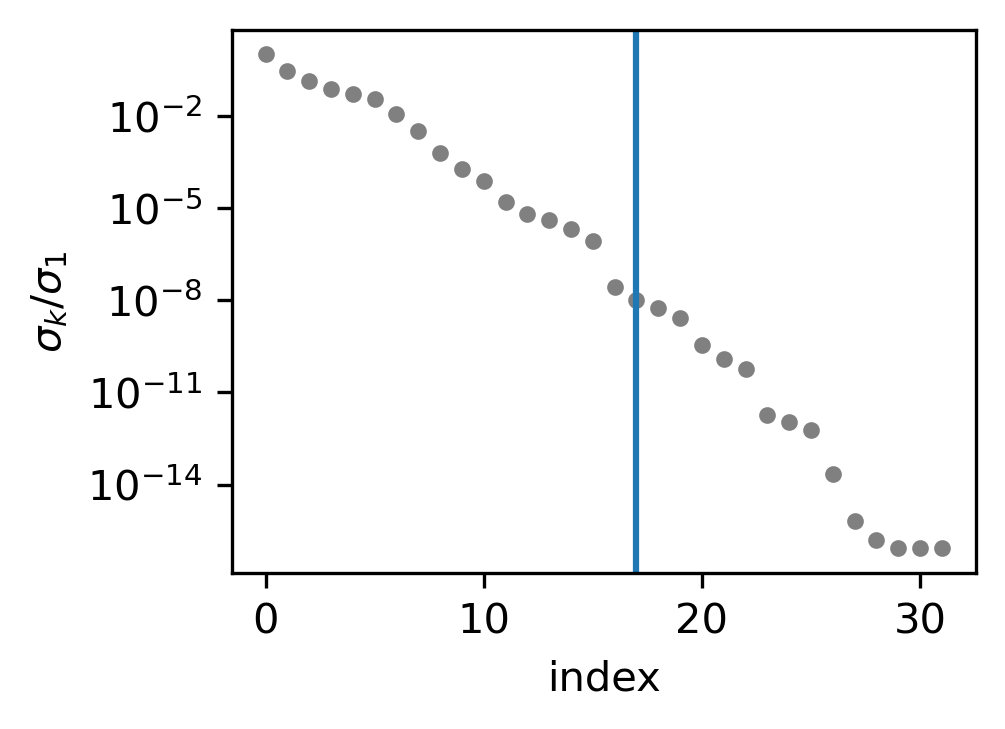

time: 466 ms


In [9]:
# compute singular value decomposition to check eps choice
u, s, vh = np.linalg.svd(A, full_matrices=True)

fig1 = plt.figure(figsize=[6.4*.5, 4.8*.5],dpi=300)
ax = fig1.add_subplot(1,1,1)
ax.semilogy(s/s[0], 'r.', color='grey')
ax.set_ylabel('$\sigma_k/\sigma_1$')
ax.set_xlabel('index')
ax.axvline([k+1]) 
if save_plot:
    plt.savefig("sv.png",bbox_inches='tight')

In [10]:
B = sli.reconstruct_skel_matrix(A, k, idx)
P = sli.reconstruct_interp_matrix(idx, proj)
C = sli.reconstruct_matrix_from_id(B, idx, proj) # C = B*P
print("B = ",B.shape)
print("P = ",P.shape)
print("C = ",C.shape)

diff = sli.estimate_spectral_norm_diff(A, C)
print("Frob Error = ",np.linalg.norm(A-C))
print("Spectral Norm of Difference = ",diff)

B =  (32, 16)
P =  (16, 100)
C =  (32, 100)
Frob Error =  1.844954129869496e-06
Spectral Norm of Difference =  1.7229423385705158e-06
time: 4.28 ms


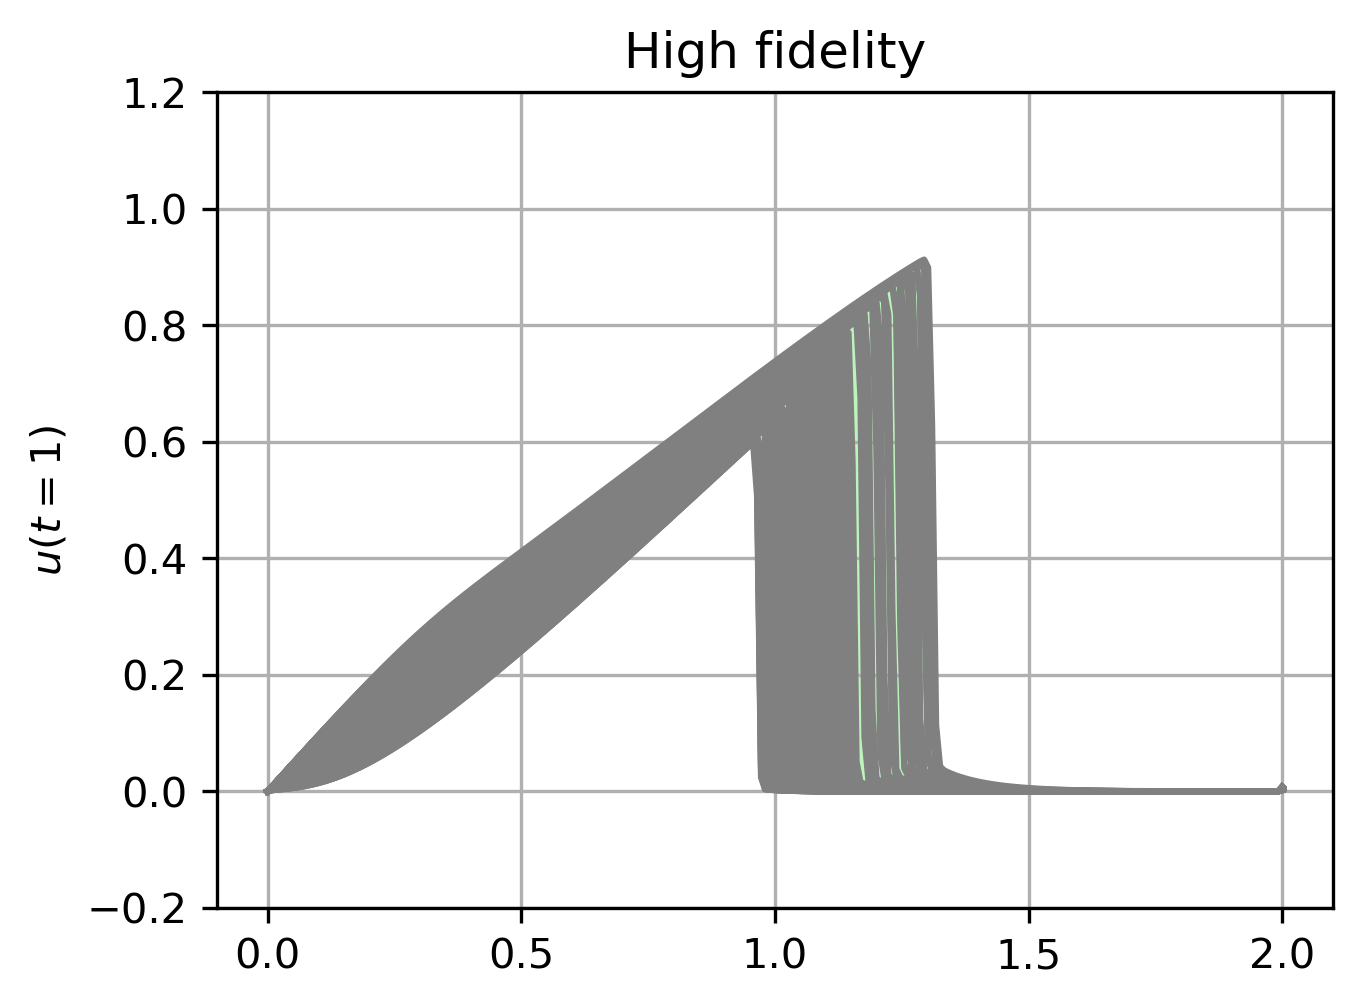

time: 398 ms


In [26]:
# plot results

X = np.linspace(0,L,nx_hf)
# generate uncertainty envelope
low_bnd = np.zeros(nx_hf)
for _ in range(nx_hf):
    low_bnd[_] = min(phi_hf[_,:])
    
upp_bnd = np.zeros(nx_hf)
for _ in range(nx_hf):
    upp_bnd[_] = max(phi_hf[_,:])

fig1 = plt.figure(figsize=[6.4*.75, 4.8*.75],dpi=300)
ax = fig1.add_subplot(1,1,1)
#ax.plot(X,phi_hf[:,idx[0:k]], '-', color='grey')
#ax.plot(X,phi_hf, '-', color='grey')
ax.plot(X,phi_check, '-', color='grey')
ax.set_ylabel('$u(t = 1)$')
ax.set_ylim([-.2,1.2])
ax.grid('on')
ax.set_title('High fidelity')
ax.fill_between(X,low_bnd,upp_bnd,color='lightgreen',alpha=0.6)      # uq bounds

if save_plot:
    plt.savefig("hf.png",bbox_inches='tight')

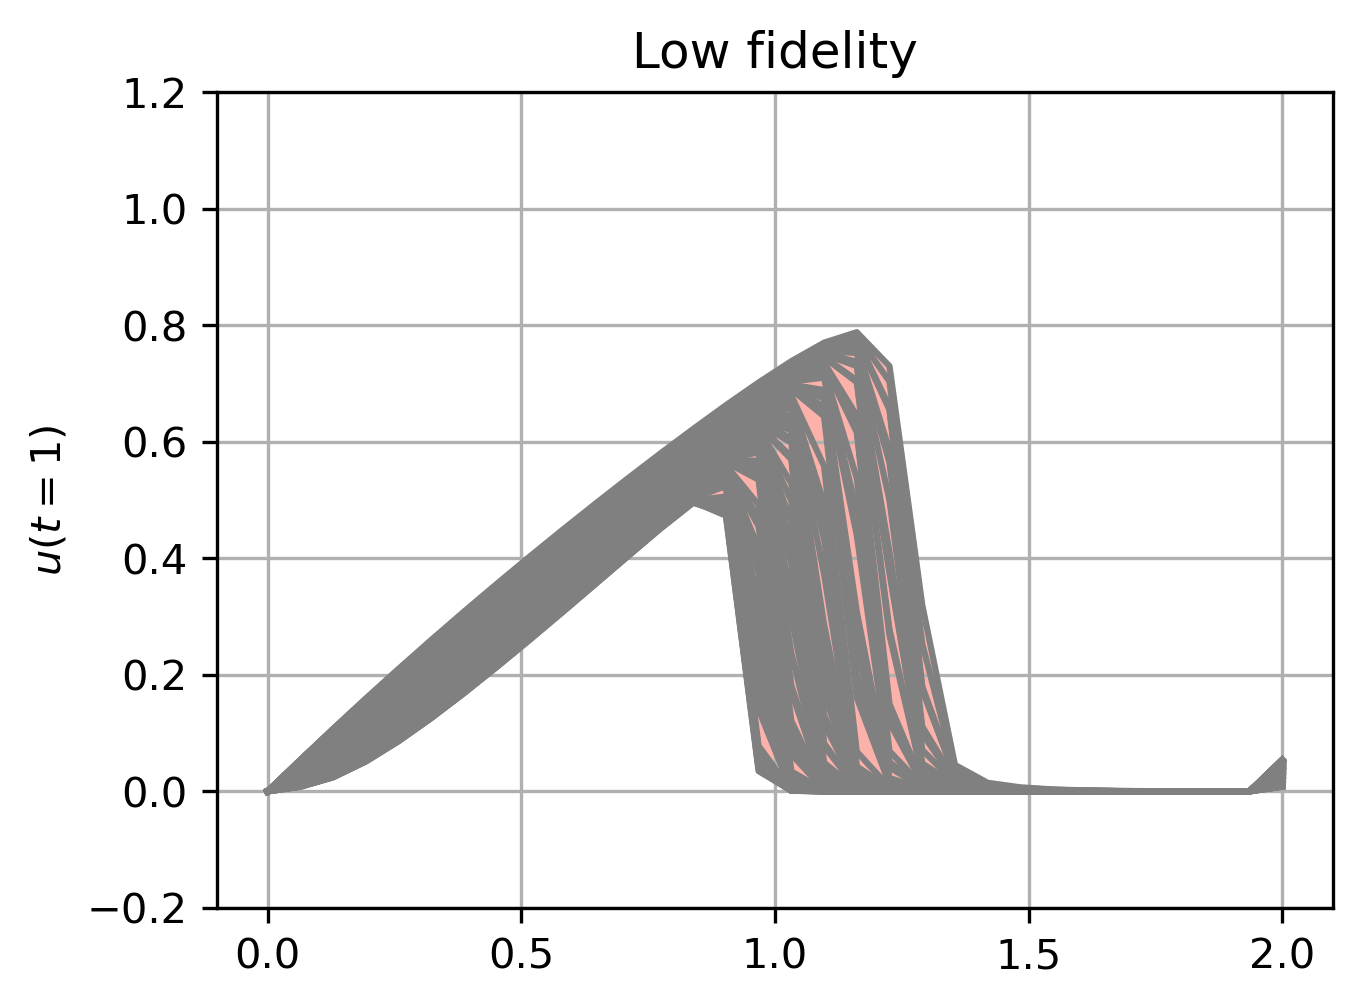

time: 338 ms


In [12]:
# plot results
X = np.linspace(0,L,nx_lf)
# generate uncertainty envelope
low_bnd = np.zeros(nx_lf)
for _ in range(nx_lf):
    low_bnd[_] = min(phi_lf[_,:])
    
upp_bnd = np.zeros(nx_lf)
for _ in range(nx_lf):
    upp_bnd[_] = max(phi_lf[_,:])

fig2 = plt.figure(figsize=[6.4*.75, 4.8*.75],dpi=300)
ax = fig2.add_subplot(1,1,1)
ax.plot(X,phi_lf, '-', color='grey')
#ax.plot(X,phi_check_up, '-', color='grey')
ax.set_ylabel('$u(t = 1)$')
ax.set_ylim([-.2,1.2])
ax.set_title('Low fidelity')
ax.grid('on')
ax.fill_between(X,low_bnd,upp_bnd,color='salmon',alpha=0.6) 

if save_plot:
    plt.savefig("lf.png",bbox_inches='tight')

In [13]:
phi_rcn = np.dot(phi_hf[:,idx[0:k]],P) # reconstructed high-fidelity solution
print(np.shape(phi_rcn))

(256, 100)
time: 1.69 ms


In [14]:
# back to original coordinates
if transf:
    shift_rcn = np.zeros(np.shape(phi_rcn))

    for _ in range(phi_rcn.shape[1]):
        #shift_rcn[:,_] = np.roll(phi_rcn[:,_], int(phi_rcn.shape[0]//2 + sloc_hf[_]))
        shift_rcn[:,_] = np.roll(phi_rcn[:,_], int(phi_rcn.shape[0]//2 + sloc_lf[_]*float(phi_hf.shape[0]/phi_lf.shape[0])))
 
    phi_rcn = shift_rcn[:]

time: 637 µs


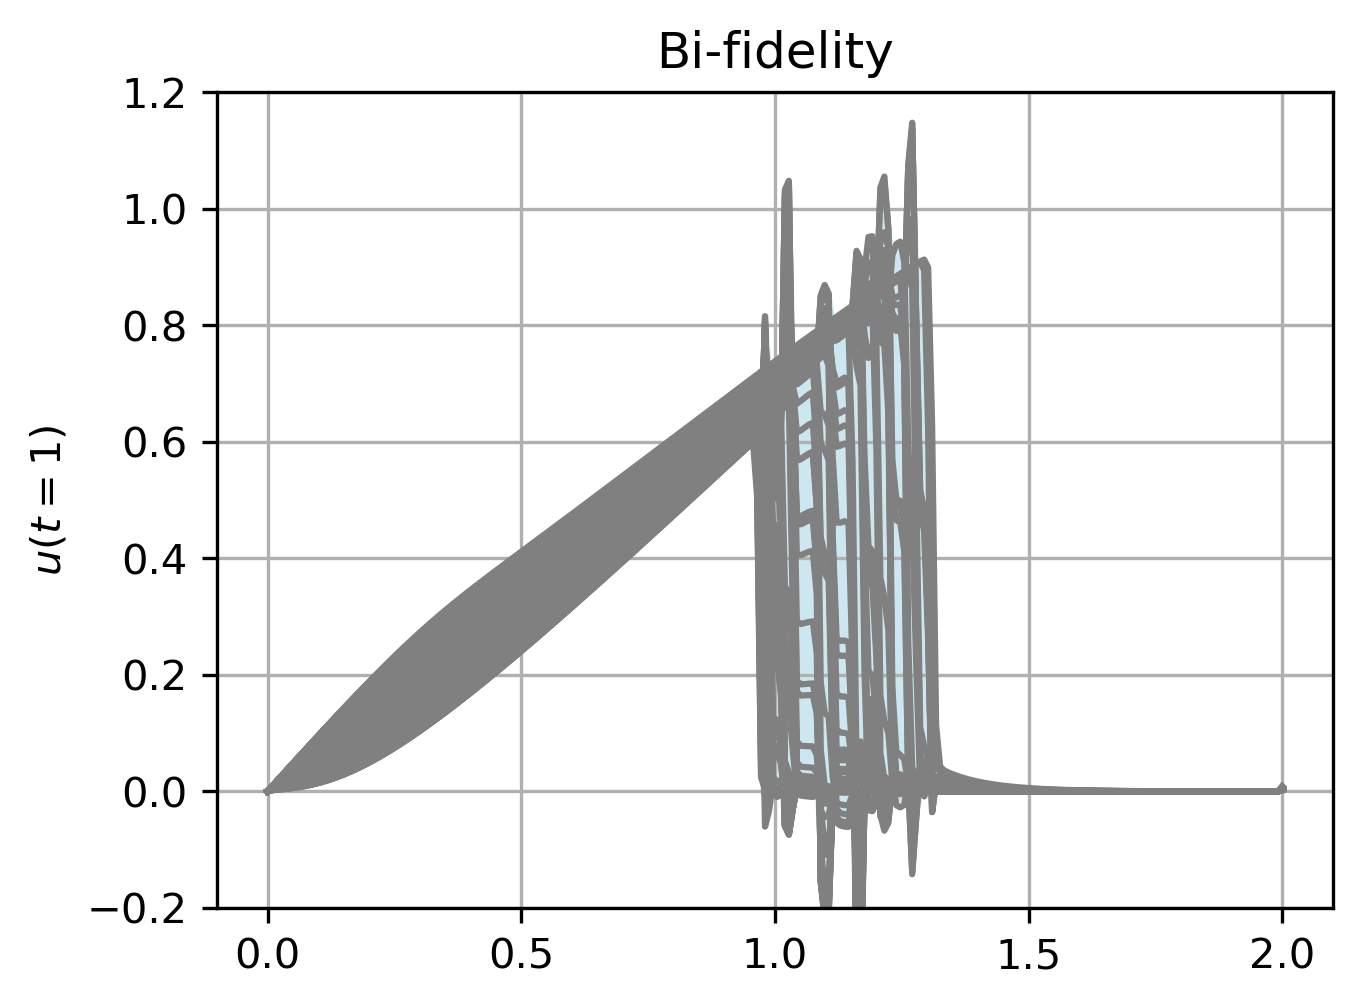

time: 345 ms


In [15]:
# plot results
X = np.linspace(0,L,nx_hf)

# generate uncertainty envelope
low_bnd = np.zeros(nx_hf)
for _ in range(nx_hf):
    low_bnd[_] = min(phi_rcn[_,:])
    
upp_bnd = np.zeros(nx_hf)
for _ in range(nx_hf):
    upp_bnd[_] = max(phi_rcn[_,:])

fig1 = plt.figure(figsize=[6.4*.75, 4.8*.75],dpi=300)
ax = fig1.add_subplot(1,1,1)
#ax.plot(X,phi_rcn[:,idx[k:]], '-', color='grey')
ax.plot(X,phi_rcn, '-', color='grey')
ax.set_ylabel('$u(t = 1)$')
ax.set_ylim([-.2,1.2])
ax.set_title('Bi-fidelity')
ax.grid('on')
ax.fill_between(X,low_bnd,upp_bnd,color='lightblue',alpha=0.6)      # uq bounds

if save_plot:
    plt.savefig("bf.png",bbox_inches='tight')

In [16]:
print("Frob Error = ",np.linalg.norm(phi_check - phi_rcn))
diff = sli.estimate_spectral_norm_diff(phi_check, phi_rcn)
print("Spectral Norm of Difference = ",diff)

Frob Error =  4.6326332538808845
Spectral Norm of Difference =  2.643758645892289
time: 4.04 ms


In [17]:
np.abs(np.linalg.norm(phi_check) - np.linalg.norm(phi_rcn))

0.04532691517614751

time: 2.03 ms
